# 1. Carga de librerías y datos

In [136]:
# Carga de librerias
import pandas as pd
import math
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa as tsm
from pmdarima.arima import auto_arima
import datetime

In [5]:
# Descarga de datos
datosaapl = pd.read_excel("https://datos-aapl.s3.amazonaws.com/datosAAPL.xlsx")
datosaapl.head()

,Date,Adj Close
0,2017-11-28,41.143055
1,2017-11-29,40.289627
2,2017-11-30,40.853031
3,2017-12-01,40.662842
4,2017-12-04,40.365696


In [42]:
# Función para calcular ACF y PACF
def acf1(x, nlags=None, acf_type="correlation", pacf=False, ax=None, **kwargs):
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == "correlation":
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = "PACF"
    else:
        if acf_type == "correlation":
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = "ACF"
        elif acf_type == "covariance":
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = "ACoV"

    if ax is None:
        ax = plt.gca()
 
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    if acf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

# 2. Ajuste del formato de la serie de tiempo

In [6]:
# Tipo de columnas actuales
datosaapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Adj Close  1258 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


In [7]:
# Poniendo de índice del DataFrame a la fecha
datosaapl.set_index('Date', inplace = True)
datosaapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-11-28 to 2022-11-25
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [8]:
datosaapl.head() # El DataFrame ya tiene un DatetimeIndex

,Adj Close
Date,
2017-11-28,41.143055
2017-11-29,40.289627
2017-11-30,40.853031
2017-12-01,40.662842
2017-12-04,40.365696


In [162]:
datosaapl_custom_business_day = datosaapl.asfreq('C') #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
datosaapl_custom_business_day[datosaapl_custom_business_day['Adj Close'].isnull()]

,Adj Close
2017-12-25,NaN
2018-01-01,NaN
2018-01-15,NaN
2018-02-19,NaN
2018-03-30,NaN
2018-05-28,NaN
2018-07-04,NaN
2018-09-03,NaN
2018-11-22,NaN
2018-12-05,NaN


# 3. Visualización

In [36]:
# Visualización de la serie de tiempo
fig = px.line(x = datosaapl.index, y = datosaapl["Adj Close"], 
              title = "Apple Share price", 
              labels = {"x": "Date", "y": "Price"}, template = "plotly_dark")
fig.show()

In [20]:
# Prueba de estacionariedad (alfa = 0.05)

# https://www.statology.org/dickey-fuller-test-python/

# Ho: La serie de tiempo no es estacionaria
# Ha: La serie de tiempo es estacionaria

adfuller(datosaapl)[1] # p-value > 0.05, la serie aún no es estacionaria

0.8194446060051142

# 4. Transformación de la serie

In [40]:
# Transformaciones de la serie

# Diferenciación para eliminar tendencia
# Transformación logarítmica para reducir variabilidad en los valores extremos
diff_log_appl = datosaapl.apply(np.log).diff().dropna()

# Visualización de la serie de tiempo diferenciada
fig = px.line(x = diff_log_appl.index, y = diff_log_appl["Adj Close"], 
              title = "Apple Share price (transformed)", 
              labels = {"x": "Date", "y": "Price"}, template = "seaborn")
fig.show()

In [55]:
# Prueba de estacionariedad a la serie diferenciada
adfuller(diff_log_appl)[1] # p-value < 0.05, la serie ya puede ser considerada como estacionaria

1.8109114665242572e-20

# 5. ACF y PACF de la serie transformada

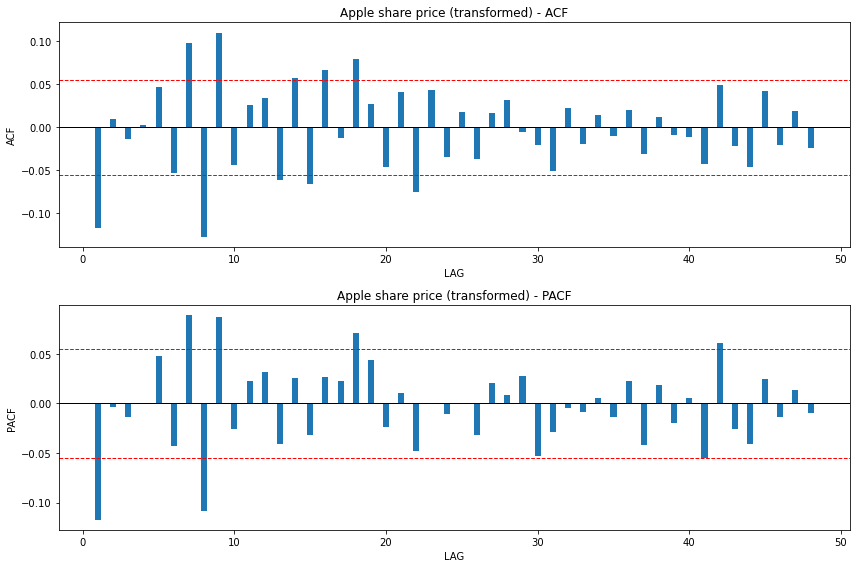

In [59]:
# ACF
fig, axes = plt.subplots(nrows = 2, figsize=(12, 8))

acf1(diff_log_appl, nlags = 48, ax = axes[0], width = .4)
axes[0].set_title("Apple share price (transformed) - ACF")

# PACF
acf1(diff_log_appl, nlags = 48, ax = axes[1], width = .4, pacf = True)
axes[1].set_title("Apple share price (transformed) - PACF")

fig.tight_layout()
plt.show()

# 6. Modelos propuestos

No se observa patrón estacional ni en la ACF (que indicaría estacionalidad en el término MA) ni en la PACF (que indicaría estacionalidad en el término AR).
#### Lags con mayor significancia por encima del umbral:
* En la ACF: 9, 8, 7 y 2 (Niveles tentativos del parámetro "q" de MA)
* En la PACF: 9, 8, 7 y 2 (Niveles tentativos del parámetro "p" de AR)

Se asume que los retrasos de mayor orden son no significativos para el armado del modelo. Se utilizará como criterio el modelo que proporcione un menor AIC, aunque también podría utilizar procedimientos más a detalle como backtesting.

In [62]:
# Serie logarítmica

In [64]:
aapl_log = datosaapl.apply(np.log)
aapl_log.head()

,Adj Close
Date,
2017-11-28,3.717055
2017-11-29,3.696094
2017-11-30,3.709981
2017-12-01,3.705315
2017-12-04,3.697980


Se iniciará probando un modelo ARIMA con rezagos específicos (2, 7, 8 y 9), tanto para los niveles de AR como MA. Como la serie fue diferenciada una única vez, el valor de I = 1.

In [65]:
p_orders = (2, 7, 8, 9)
q_orders = (2, 7, 8, 9)

In [107]:
# Modelo 1 (rezagos específicos)
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

modelo_uno = sm.tsa.SARIMAX(aapl_log, order = (p_orders, 1, q_orders), trend = None).fit()
# El warning de date index se debe a que se está trabajando con trading days
modelo_uno.summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                  Adj Close   No. Observations:                 1258
Model:             SARIMAX([2, 7, 8, 9], 1, [2, 7, 8, 9])   Log Likelihood                3098.621
Date:                                    Fri, 02 Dec 2022   AIC                          -6179.241
Time:                                            21:27:40   BIC                          -6133.013
Sample:                                                 0   HQIC                         -6161.867
                                                   - 1258                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.0079      0.162     -0.049      0.961      -0.326       0.310
ar.L7          0.4406      0.177      2.492      0.013       0.094       0.787
ar.L8         -0.0638      0.246     -0.259      0.796      -0.547       0.419
ar.L9          0.1310      0.233      0.563      0.574      -0.325       0.587
ma.L2         -0.0062      0.169     -0.037      0.970      -0.337       0.324
ma.L7         -0.3626      0.184     -1.969      0.049      -0.723      -0.002
ma.L8         -0.0342      0.251     -0.136      0.892      -0.526       0.458
ma.L9         -0.0351      0.227     -0.154      0.877      -0.480       0.410
sigma2         0.0004   1.11e-05     37.951      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   9.49   Jarque-Bera (JB):               744.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.28
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A continuación, se probará con modelos en dónde p = q, para los órdenes (9, 8, 7, 2). Se optará por no probar modelos en donde p != q por 2 motivos: el primero es porque el problema se volvería extenso (demasiados modelos por probar), mientras que el segundo es que según las gráficas de ACF y PACF, cuando un rezago es significativo en el ACF (que da indicios del nivel q de MA), también es significativo en el PACF (que da indicios del nivel p de AR), para los rezagos de temporalidad menores al 10° rezago.

In [99]:
# Modelo 2 (rezagos altos)
modelo_dos = sm.tsa.SARIMAX(aapl_log, order = (9, 1, 9), trend = None).fit()
# El warning de date index se debe a que se está trabajando con trading days
modelo_dos.summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1258
Model:               SARIMAX(9, 1, 9)   Log Likelihood                3107.301
Date:                Fri, 02 Dec 2022   AIC                          -6176.601
Time:                        21:23:57   BIC                          -6079.008
Sample:                             0   HQIC                         -6139.923
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4471      0.516      0.866      0.386      -0.565       1.459
ar.L2          0.3857      0.389      0.992      0.321      -0.376       1.148
ar.L3         -0.2815      0.561     -0.502      0.616      -1.381       0.818
ar.L4         -0.4516      0.464     -0.973      0.330      -1.361       0.458
ar.L5          0.1595      0.644      0.248      0.805      -1.104       1.423
ar.L6          0.0324      0.407      0.080      0.937      -0.766       0.830
ar.L7          0.1097      0.404      0.271      0.786      -0.683       0.902
ar.L8         -0.2317      0.292     -0.794      0.427      -0.804       0.340
ar.L9          0.2886      0.304      0.948      0.343      -0.308       0.885
ma.L1         -0.5397      0.523     -1.032      0.302      -1.564       0.485
ma.L2         -0.3626      0.416     -0.872      0.383      -1.177       0.452
ma.L3          0.3257      0.562      0.580      0.562      -0.775       1.426
ma.L4          0.4431      0.488      0.908      0.364      -0.514       1.400
ma.L5         -0.1713      0.655     -0.261      0.794      -1.456       1.113
ma.L6         -0.0621      0.429     -0.145      0.885      -0.902       0.778
ma.L7         -0.0183      0.435     -0.042      0.967      -0.871       0.834
ma.L8          0.1319      0.278      0.474      0.636      -0.414       0.678
ma.L9         -0.1956      0.289     -0.676      0.499      -0.763       0.372
sigma2         0.0004   1.19e-05     34.954      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               599.98
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.29
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
# Modelo 3
modelo_tres = sm.tsa.SARIMAX(aapl_log, order = (8, 1, 8), trend = None).fit()
# El warning de date index se debe a que se está trabajando con trading days
modelo_tres.summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1258
Model:               SARIMAX(8, 1, 8)   Log Likelihood                3102.641
Date:                Fri, 02 Dec 2022   AIC                          -6171.281
Time:                        21:28:14   BIC                          -6083.961
Sample:                             0   HQIC                         -6138.464
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0973      2.102     -0.046      0.963      -4.218       4.023
ar.L2          0.0825      2.097      0.039      0.969      -4.028       4.193
ar.L3         -0.0823      1.562     -0.053      0.958      -3.145       2.980
ar.L4          0.0878      1.405      0.062      0.950      -2.666       2.842
ar.L5          0.0709      0.844      0.084      0.933      -1.584       1.725
ar.L6         -0.0714      0.534     -0.134      0.894      -1.119       0.976
ar.L7          0.1097      0.476      0.231      0.818      -0.822       1.042
ar.L8         -0.2848      0.541     -0.526      0.599      -1.346       0.776
ma.L1          0.0054      2.102      0.003      0.998      -4.114       4.124
ma.L2         -0.1042      1.912     -0.054      0.957      -3.852       3.644
ma.L3          0.0979      1.365      0.072      0.943      -2.577       2.772
ma.L4         -0.0999      1.268     -0.079      0.937      -2.586       2.386
ma.L5         -0.0047      0.731     -0.006      0.995      -1.437       1.427
ma.L6          0.0369      0.501      0.074      0.941      -0.944       1.018
ma.L7         -0.0517      0.457     -0.113      0.910      -0.947       0.844
ma.L8          0.2201      0.440      0.501      0.617      -0.642       1.082
sigma2         0.0004   1.19e-05     35.012      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               713.78
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.33
Prob(H) (two-sided):                  0.13   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
# Modelo 4
modelo_cuatro = sm.tsa.SARIMAX(aapl_log, order = (7, 1, 7), trend = None).fit()
# El warning de date index se debe a que se está trabajando con trading days
modelo_cuatro.summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1258
Model:               SARIMAX(7, 1, 7)   Log Likelihood                3098.739
Date:                Fri, 02 Dec 2022   AIC                          -6167.477
Time:                        21:29:04   BIC                          -6090.430
Sample:                             0   HQIC                         -6138.520
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0908      2.402     -0.038      0.970      -4.799       4.617
ar.L2          0.1456      2.588      0.056      0.955      -4.927       5.218
ar.L3         -0.1868      2.214     -0.084      0.933      -4.527       4.153
ar.L4          0.1450      2.643      0.055      0.956      -5.036       5.326
ar.L5          0.0588      1.743      0.034      0.973      -3.358       3.475
ar.L6         -0.0726      1.554     -0.047      0.963      -3.118       2.972
ar.L7          0.3381      1.362      0.248      0.804      -2.331       3.007
ma.L1          0.0061      2.402      0.003      0.998      -4.701       4.714
ma.L2         -0.1378      2.641     -0.052      0.958      -5.314       5.038
ma.L3          0.2149      2.223      0.097      0.923      -4.142       4.572
ma.L4         -0.1806      2.674     -0.068      0.946      -5.422       5.060
ma.L5          0.0464      1.865      0.025      0.980      -3.608       3.701
ma.L6          0.0418      1.307      0.032      0.974      -2.521       2.604
ma.L7         -0.2830      1.194     -0.237      0.813      -2.624       2.058
sigma2         0.0004   1.17e-05     35.881      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               721.07
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.26
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
# Modelo 5
modelo_cinco = sm.tsa.SARIMAX(aapl_log, order = (2, 1, 2), trend = None).fit()
# El warning de date index se debe a que se está trabajando con trading days
modelo_cinco.summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1258
Model:               SARIMAX(2, 1, 2)   Log Likelihood                3083.317
Date:                Fri, 02 Dec 2022   AIC                          -6156.633
Time:                        21:51:16   BIC                          -6130.951
Sample:                             0   HQIC                         -6146.981
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9696      0.164      5.905      0.000       0.648       1.291
ar.L2         -0.0465      0.165     -0.282      0.778      -0.370       0.277
ma.L1         -1.0857      0.166     -6.532      0.000      -1.411      -0.760
ma.L2          0.1661      0.166      0.999      0.318      -0.160       0.492
sigma2         0.0004   1.04e-05     41.550      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               941.94
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.24
Prob(H) (two-sided):                  0.12   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Finalmente, una alternativa es utilizar la función auto_arima del paquete pmdarima para determinar los niveles de p y q.

In [112]:
auto_arima(aapl_log, seasonal = False)

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [113]:
# Probando con los niveles indicados por la función auto_arima
# Modelo 6
modelo_seis = sm.tsa.SARIMAX(aapl_log, order = (1, 1, 0), trend = None).fit()
# El warning de date index se debe a que se está trabajando con trading days
modelo_seis.summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1258
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3082.536
Date:                Fri, 02 Dec 2022   AIC                          -6161.073
Time:                        21:54:50   BIC                          -6150.800
Sample:                             0   HQIC                         -6157.212
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1144      0.018     -6.228      0.000      -0.150      -0.078
sigma2         0.0004   1.04e-05     41.674      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               951.19
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.29
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se observa que el modelo que presenta el mejor AIC es el modelo uno con rezagos específicos. Sin embargo, la prueba de Ljung-box a los residuales exhibe una falta de ajuste del modelo al momento de examinar las autocorrelaciones de los residuales (p-value = 0 < alfa = 0.05).

Por ende, se opta por usar el segundo mejor modelo, el modelo dos --> ARIMA(9,1,9), que brinda el segundo menor AIC posible y no exhibe una falta de ajuste (p-value Ljung-box test = 0.84 > alfa = 0.05).

# 7. Diagnóstico del modelo

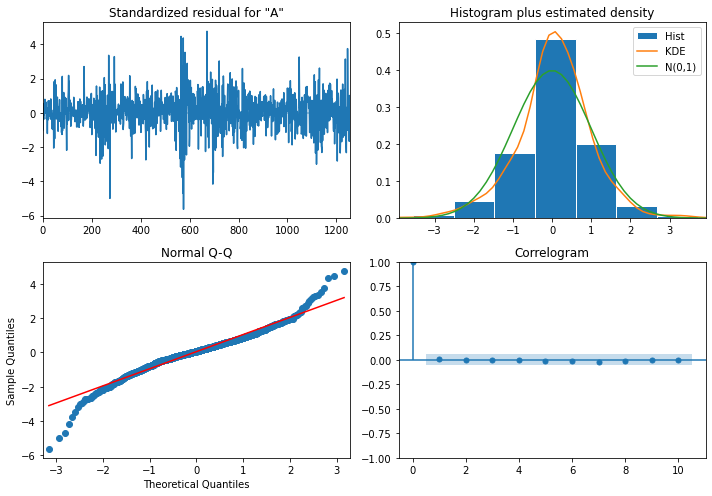

In [116]:
fig = modelo_dos.plot_diagnostics(figsize=(10, 7))
fig.tight_layout()
plt.show()

* Los residuales tienen media constante y cercana a 0, y aparentan tener media constante
* El Q-Q plot evidencia un ajuste regular al modelo, considerando que esta gráfica tiende a aumentar la diferencia en los extremos
* Además, el correlograma no evidencia autocorrelación entre los residuales


# 8. Pronóstico

In [236]:
# Dado que los datos son mensuales, se ejemplifica el pronóstico de una semana en el nivel original

forecast = modelo_dos.get_forecast(7)
forecast_index = pd.date_range(datosaapl.index[-1] + datetime.timedelta(days=1),periods=7, freq='d')

forecast_mean = np.exp(modelo_dos.get_forecast(7) .predicted_mean)
forecast_mean.index = forecast_index

se_mean = np.exp(modelo_dos.get_forecast(7).se_mean)
se_mean.index = forecast_index


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



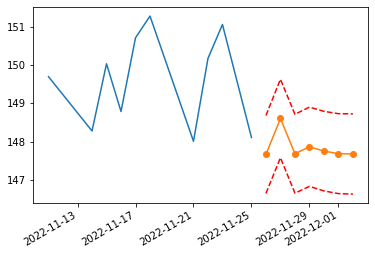

In [239]:
# Dado que los datos son diarios, se ejemplifica el pronóstico de una semana
#https://www.statsmodels.org/v0.13.0/examples/notebooks/generated/statespace_forecasting.html
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_forecast.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_forecast
plt.plot(datosaapl.index[-10:], datosaapl["Adj Close"][-10:])
forecast_mean.plot(marker="o")
plt.plot(forecast_mean + se_mean, color="red", linestyle="--")
plt.plot(forecast_mean - se_mean, color="red", linestyle="--")
plt.show()                     
